In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision import models
from PIL import Image
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS

# Step 1 #

In [14]:
# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=True)

alexnet.eval()

/Users/michaelruiz/Documents/Coding/Python/CS 4442/A4/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/michaelruiz/Documents/Coding/Python/CS 4442/A4/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
# Identify layers of interest
layers_of_interest = {
    'conv1': alexnet.features[0],
    'conv2': alexnet.features[3],
    'conv3': alexnet.features[6],
    'conv4': alexnet.features[8],
    'conv5': alexnet.features[10],
    'fc6': alexnet.classifier[1],
    'fc7': alexnet.classifier[4]
}

feature_maps = {name: [] for name in layers_of_interest.keys()}

# Define a hook function
def hook(self, input, output):
    batch_output = output.detach().cpu()
    if self in layers_of_interest.values():
        layer_name = [name for name, layer in layers_of_interest.items() if layer == self][0]
        feature_maps[layer_name].append(batch_output)

for layer in layers_of_interest.values():
    layer.register_forward_hook(hook)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_folder = './Image_Set'
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)
    alexnet(image_tensor)

for layer_name, activations in feature_maps.items():
    print(f'Layer: {layer_name} - Total activations: {len(activations)}')

Layer: conv1 - Total activations: 156
Layer: conv2 - Total activations: 156
Layer: conv3 - Total activations: 156
Layer: conv4 - Total activations: 156
Layer: conv5 - Total activations: 156
Layer: fc6 - Total activations: 156
Layer: fc7 - Total activations: 156


# Step 2 #

In [16]:
rdms = {}

for layer_name, activations in feature_maps.items():
    if activations:
        # Flattening the activations into 2D (# images, # features)
        activations_np = np.vstack([activation.view(activation.size(0), -1).numpy() for activation in activations])
        distances = pdist(activations_np, 'euclidean')
        rdm = squareform(distances)
        rdms[layer_name] = rdm
    else:
        print(f'No activations for layer: {layer_name}')

print(rdms)

{'conv1': array([[  0.        , 663.36676928, 589.24327531, ..., 592.38157785,
        593.62636188, 567.17895367],
       [663.36676928,   0.        , 607.38970554, ..., 598.48252571,
        625.02954486, 593.35253629],
       [589.24327531, 607.38970554,   0.        , ..., 543.6160097 ,
        559.02771143, 517.33688462],
       ...,
       [592.38157785, 598.48252571, 543.6160097 , ...,   0.        ,
        534.45901264, 500.85664257],
       [593.62636188, 625.02954486, 559.02771143, ..., 534.45901264,
          0.        , 496.68817227],
       [567.17895367, 593.35253629, 517.33688462, ..., 500.85664257,
        496.68817227,   0.        ]]), 'conv2': array([[  0.        , 757.08316004, 690.73755339, ..., 770.88014553,
        784.79233205, 752.65061128],
       [757.08316004,   0.        , 659.52811981, ..., 729.22633217,
        753.30725243, 721.32799076],
       [690.73755339, 659.52811981,   0.        , ..., 687.4546869 ,
        708.00716102, 671.32356457],
       ...,
 

# Step 3 #

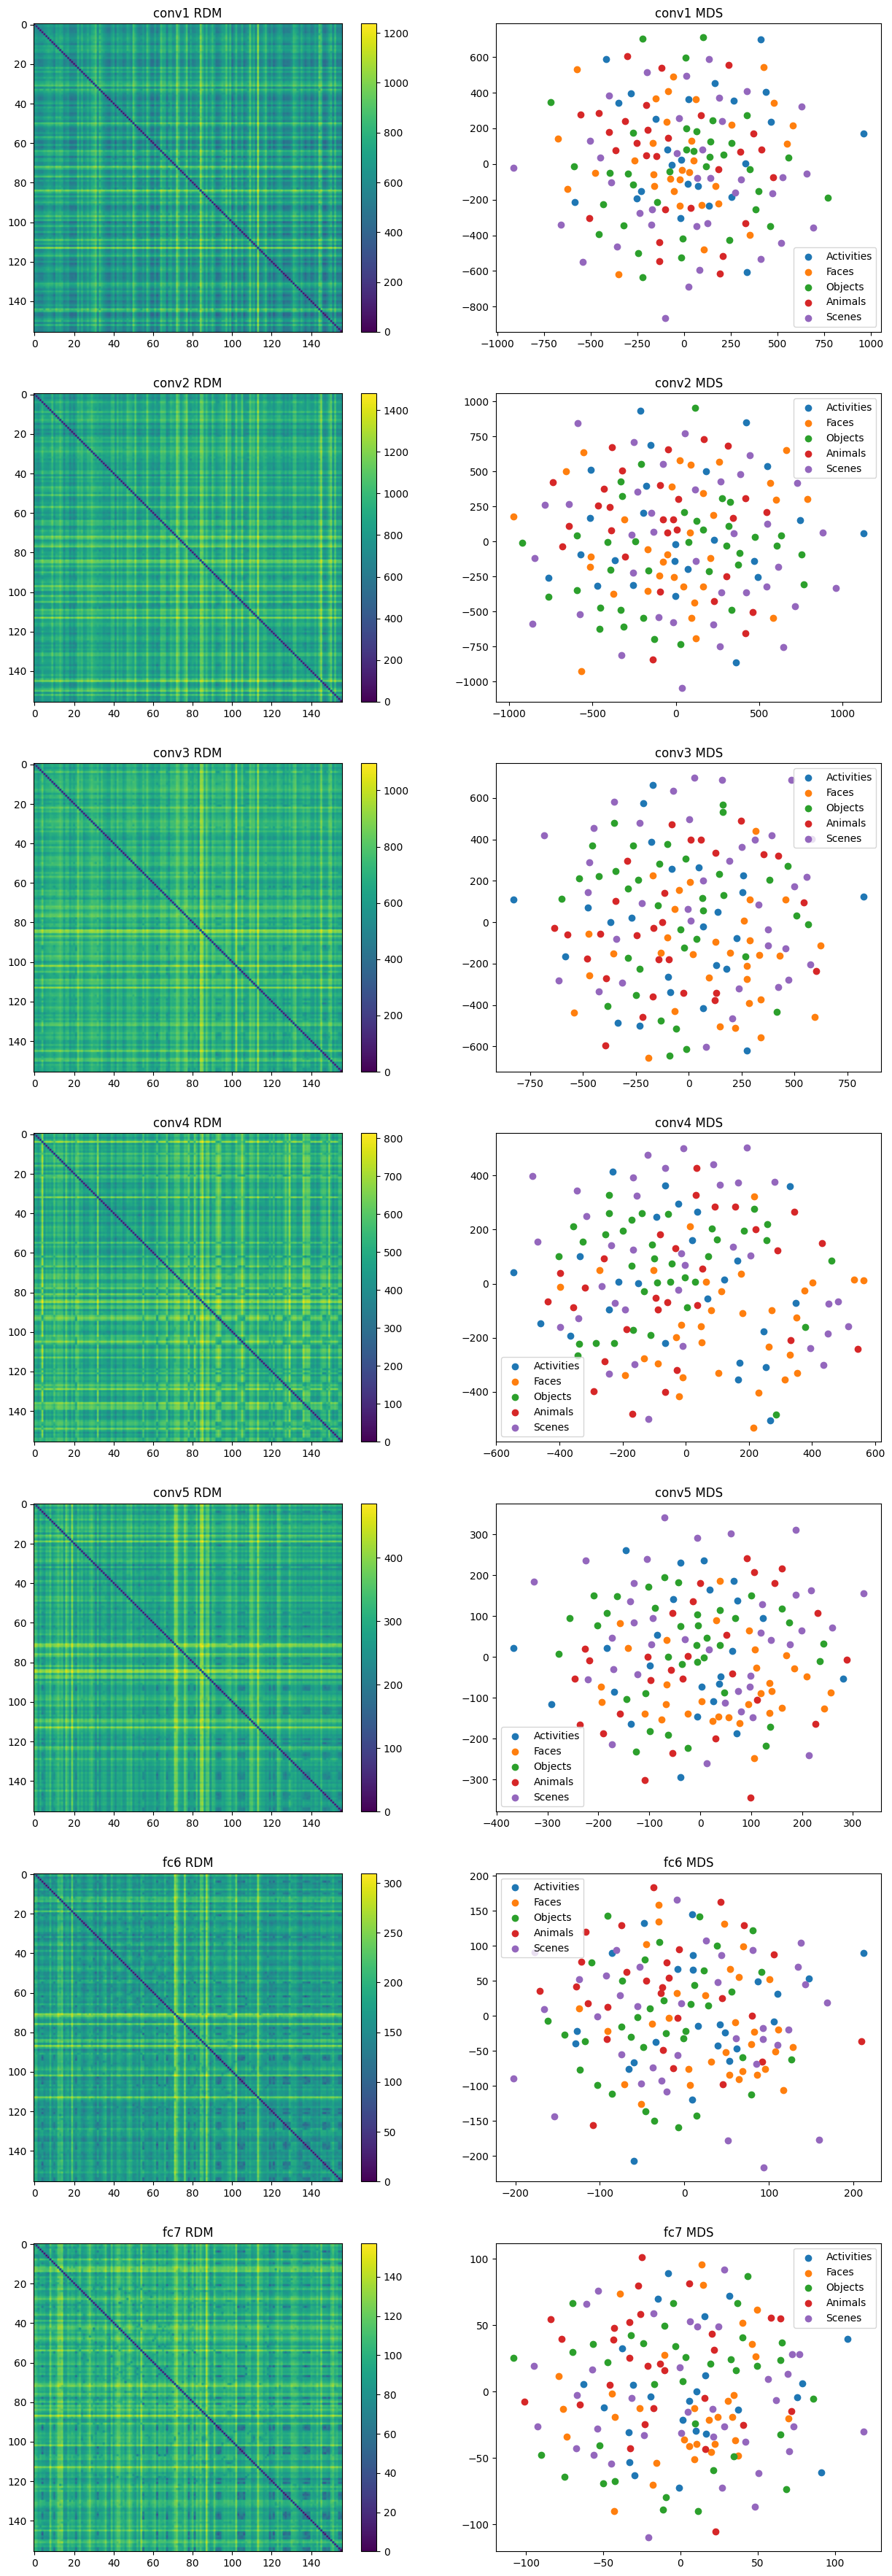

In [17]:
labels = [
    'Animals' if i < 29 else 'Objects' if i < 65 else 'Scenes' if i < 101 else 'Activities' if i < 125 else 'Faces'
    for i in range(1, 157)]

fig, axes = plt.subplots(7, 2, figsize=(15, 45))

for i, (layer_name, rdm) in enumerate(rdms.items()):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_res = mds.fit_transform(rdm)

    ax_rdm = axes[i, 0]
    imshow = ax_rdm.imshow(rdm, cmap='viridis')
    fig.colorbar(imshow, ax=ax_rdm)
    ax_rdm.set_title(f'{layer_name} RDM')

    ax_mds = axes[i, 1]
    for y in set(labels):
        ix = np.where(np.array(labels) == y)
        ax_mds.scatter(mds_res[ix, 0], mds_res[ix, 1], label=y)
    ax_mds.set_title(f'{layer_name} MDS')
    ax_mds.legend()

plt.show()

# Step 4 #
This lab investigates the use of a pre-trained AlexNet model to analyze and visualize layer activations. It employs images sorted into five categories as input and focuses on specific layers within the AlexNet architecture. The aim is to extract feature maps, compute Representational Dissimilarity Matrices (RDMs), and visualize them to understand how the model processes data and learns representations. While convolutional layers lack a clear pattern in RDM heatmap and Multi Dimensional Scaling (MDS) plot, as expected, the final fully connected layer shows higher similarity among certain photos, particularly in human activities and faces categories. This indicates successful identification of relationships, which aligns with the role of fully connected layers in classification tasks.